# <a id='toc1_'></a>[Prototipo de modelo de machine learning para Zyfra](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Prototipo de modelo de machine learning para Zyfra](#toc1_)    
  - [Introducción](#toc1_1_)    
  - [Carga de archivos y librerías](#toc1_2_)    
  - [Vista General de los datos](#toc1_3_)    
  - [Exploración de los datos](#toc1_4_)    
    - [Cálculo de recuperación y EAM](#toc1_4_1_)    
    - [Caracteristicas no disponibles en el conjunto de prueba](#toc1_4_2_)    
    - [Preprocesamiento de datos](#toc1_4_3_)    
    - [Analizando los datos](#toc1_4_4_)    
  - [Construyendo el modelo](#toc1_5_)    
    - [Evaluando modelo final](#toc1_5_1_)    
  - [Conclusiones finales](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Introducción](#toc0_)

A continuación vamos a construir un modelo debe predecir la cantidad de oro extraído del mineral de oro. El modelo ayudará a optimizar la producción y a eliminar los parámetros no rentables. La métrica con la que evaluaremos nuestro modelo será el *sMAPE* para cada variable objetivo, teniendo una métrica final *sMAPE final*.

## <a id='toc1_2_'></a>[Carga de archivos y librerías](#toc0_)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
data_train = pd.read_csv('/datasets/gold_recovery_train.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test.csv')
data_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
RANDOM_STATE = 54321

## <a id='toc1_3_'></a>[Vista General de los datos](#toc0_)

In [4]:
def overview_data(_data):
    shape = _data.shape
    na_values_count = ((_data.isna().sum()[_data.isna().sum() > 0]).sort_values(ascending=False))
    na_values_proportion = ((_data.isna().mean()[_data.isna().sum() > 0]).sort_values(ascending=False)).apply(lambda x: f'{x:0.2%}')
    na_values = pd.DataFrame(
        {"Count": na_values_count, "Proportion": na_values_proportion}
    )
    dtypes = _data.dtypes.value_counts()
    print('Tamaño:', shape, end='\n-----------\n\n')
    print(f'Tipos de dato: \n\n{dtypes}', end='\n-----------\n\n')
    print(f'Valores ausentes: \n{na_values.head(20)}', end='\n-----------\n')
    display(_data.head())

In [5]:
overview_data(data_train)

Tamaño: (16860, 87)
-----------

Tipos de dato: 

float64    86
object      1
dtype: int64
-----------

Valores ausentes: 
                                          Count Proportion
rougher.output.recovery                    2573     15.26%
rougher.output.tail_ag                     2250     13.35%
rougher.output.tail_au                     2249     13.34%
rougher.output.tail_sol                    2249     13.34%
secondary_cleaner.output.tail_sol          1986     11.78%
rougher.input.floatbank11_xanthate         1904     11.29%
final.output.recovery                      1521      9.02%
primary_cleaner.input.sulfate              1307      7.75%
primary_cleaner.input.depressant           1262      7.49%
rougher.calculation.au_pb_ratio            1242      7.37%
rougher.input.floatbank10_sulfate          1044      6.19%
primary_cleaner.input.xanthate              985      5.84%
primary_cleaner.output.concentrate_sol      636      3.77%
rougher.input.floatbank11_sulfate           623    

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [6]:
overview_data(data_test)

Tamaño: (5856, 53)
-----------

Tipos de dato: 

float64    52
object      1
dtype: int64
-----------

Valores ausentes: 
                                          Count Proportion
rougher.input.floatbank11_xanthate          353      6.03%
primary_cleaner.input.sulfate               302      5.16%
primary_cleaner.input.depressant            284      4.85%
rougher.input.floatbank10_sulfate           257      4.39%
primary_cleaner.input.xanthate              166      2.83%
rougher.input.floatbank10_xanthate          123      2.10%
rougher.input.feed_sol                       67      1.14%
rougher.input.floatbank11_sulfate            55      0.94%
rougher.input.feed_rate                      40      0.68%
secondary_cleaner.state.floatbank3_a_air     34      0.58%
secondary_cleaner.state.floatbank2_b_air     23      0.39%
rougher.input.feed_size                      22      0.38%
secondary_cleaner.state.floatbank2_a_air     20      0.34%
rougher.state.floatbank10_f_air              17     

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [7]:
overview_data(data_full)

Tamaño: (22716, 87)
-----------

Tipos de dato: 

float64    86
object      1
dtype: int64
-----------

Valores ausentes: 
                                        Count Proportion
rougher.output.recovery                  3119     13.73%
rougher.output.tail_ag                   2737     12.05%
rougher.output.tail_au                   2736     12.04%
rougher.output.tail_sol                  2736     12.04%
rougher.input.floatbank11_xanthate       2257      9.94%
secondary_cleaner.output.tail_sol        2215      9.75%
final.output.recovery                    1963      8.64%
rougher.calculation.au_pb_ratio          1627      7.16%
primary_cleaner.input.sulfate            1609      7.08%
primary_cleaner.input.depressant         1546      6.81%
rougher.input.floatbank10_sulfate        1301      5.73%
primary_cleaner.input.xanthate           1151      5.07%
primary_cleaner.output.concentrate_sol    798      3.51%
rougher.input.floatbank11_sulfate         678      2.98%
rougher.state.floatban

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


**Observaciones**

Podemos observar como en los tres conjuntos de datos tenemos la presencia de valores ausentes, notamos también que el conjunto de datos de prueba cuenta con menos columnas que el conjunto de entrenamiento y completo. Con excepción de la columna `date` el resto son de tipo *float*.

## <a id='toc1_4_'></a>[Exploración de los datos](#toc0_)

### <a id='toc1_4_1_'></a>[Cálculo de recuperación y EAM](#toc0_)

Comprobaremos que el cálculo de la recuperación sea correcto.

$$
Recuperación = \frac{C \times (F-T)}{F \times (C-T)} \times 100\%
$$

> * <small>C — proporción de oro en el concentrado justo después de la flotación (para saber la recuperación del concentrado >rougher)/después de la purificación (para saber la recuperación del concentrado final)</small>
> * <small>F — la proporción de oro en la alimentación antes de la flotación (para saber la recuperación del concentrado rougher)/en el concentrado justo después de la flotación (para saber la recuperación del concentrado final)</small>
> * <small>T — la proporción de oro en las colas rougher justo después de la flotación (para saber la recuperación del concentrado rougher)/después de la purificación (para saber la recuperación del concentrado final)</small>

In [8]:
C = data_train['rougher.output.concentrate_au']
F = data_train['rougher.input.feed_au']
T = data_train['rougher.output.tail_au']

In [9]:
calc_rougher_recovery = (C * (F-T)) / (F * (C-T)) * 100

In [10]:
rougher_recovery = data_train['rougher.output.recovery']

*EAM*

$$
MAE = \frac{1}{n} \sum_{j=1}^{n} |y_j - \hat{y}_j|
$$

In [11]:
(calc_rougher_recovery - rougher_recovery).abs().mean()

9.303415616264301e-15

**Observaciones**

Como resultado de la comparativa de la característica en nuestro conjunto respecto al calculo realizado tenemos un *EAM* de **9.3e-15**, un número sumamente pequeño que nos indica que nuestro cálculo es bastante cercano al de la característica. 

### <a id='toc1_4_2_'></a>[Caracteristicas no disponibles en el conjunto de prueba](#toc0_)

Analicemos las características no disponibles en el conjunto de prueba.

In [12]:
cols_tests_unavailable = data_train.columns.difference(data_test.columns)
print(cols_tests_unavailable.size)
cols_tests_unavailable.sort_values(ascending=False)

34


Index(['secondary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_pb',
       'secondary_cleaner.output.tail_au', 'secondary_cleaner.output.tail_ag',
       'rougher.output.tail_sol', 'rougher.output.tail_pb',
       'rougher.output.tail_au', 'rougher.output.tail_ag',
       'rougher.output.recovery', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_ag',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'primary_cleaner.output.tail_sol',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_ag',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.o

In [13]:
data_train[cols_tests_unavailable].dtypes.value_counts()

float64    34
dtype: int64

**Observaciones**

Podemos notar como las columnas no disponibles en el conjunto de prueba que si están en el de entrenamiento son aquellas que son referencia al tipo de parámetro *output* o *calculation*, puede deberse a ser mediciones o cálculos realizados posteriormente.

### <a id='toc1_4_3_'></a>[Preprocesamiento de datos](#toc0_)

Observando el porcentaje de valores ausentes y el tamaño de nuestros conjuntos, tomaremos el camino de descartar los valores ausentes, la intención es utilizar solo valores existentes, sin intentar hacer imputaciones que puedan extender errores en nuestro modelo.

In [14]:
data_train = data_train.dropna(how='any')
data_test = data_test.dropna(how='any')
data_full = data_full.dropna(how='any')

In [15]:
print('train:', data_train.shape)
print('test:', data_test.shape)
print('full:', data_full.shape)

train: (11017, 87)
test: (5383, 53)
full: (16094, 87)


In [16]:
data_train.isna().sum().sum()

0

### <a id='toc1_4_4_'></a>[Analizando los datos](#toc0_)

**Cambio de concentración de metales en cada etapa de purificación**

Observa cómo cambia la concentración de metales (Au, Ag, Pb) en función de la etapa de purificación.

In [17]:
steps = ['rougher.input.feed_','rougher.output.concentrate_','primary_cleaner.output.concentrate_',
         'final.output.concentrate_']
metals = ["au","ag","pb", "sol"]

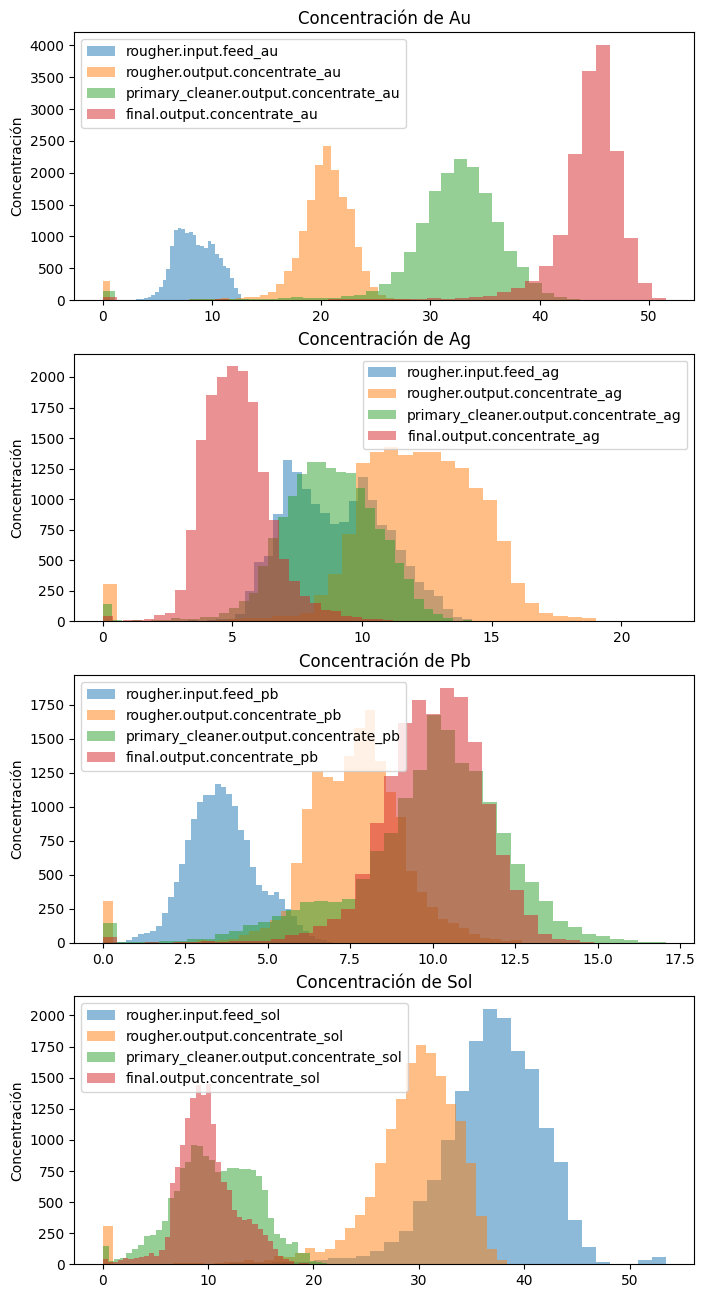

In [18]:
fig, ax = plt.subplots(4, 1, figsize=(8, 16))
for i, m in enumerate(metals):
    for s in steps:
        variable = s+m
        ax[i].hist(data_full[variable], alpha=0.5, bins=40, label=variable)
    ax[i].legend()
    ax[i].set_title(f"Concentración de {m.capitalize()}")
    ax[i].set_ylabel("Concentración")

**Observaciones**

Podemos observar como a lo largo de las diferentes etapas es `Au` que etapa con etapa incrementa su concentración, caso contrario de `Ag` y `Sol` que tiende a disminuir, solo siendo `Pb` que en la penúltima y última etapa se mantiene de forma muy similar su concentración, se observan en todos los metales observaciones en cuya concentración es cercana a cero, presente en casi todas las etapas.

**Confirmando distribución de rougher.input.feed_size en el conjunto de prueba y entrenamiento**

Comparemos las distribuciones del *tamaño de las partículas de la alimentación* en el conjunto de *entrenamiento* y en el conjunto de *prueba* ya que si las distribuciones varían significativamente, la evaluación del modelo no será correcta.

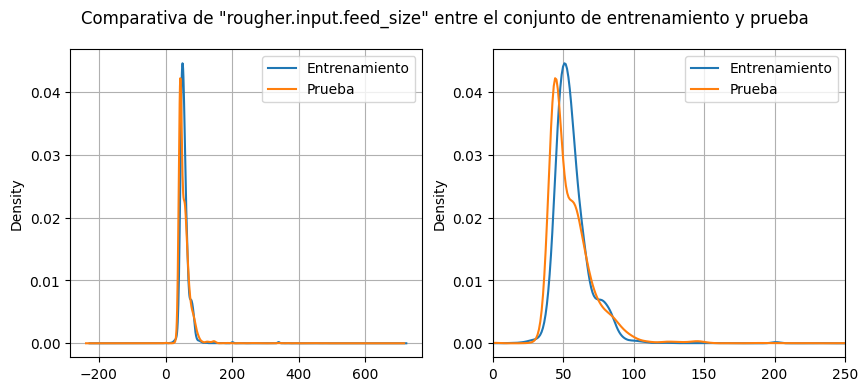

In [19]:
input_feed = 'rougher.input.feed_size'
fig, ax = plt.subplots(1,2, figsize=(10, 4))
data_train[input_feed].plot.kde(ax=ax[0], label='Entrenamiento')
data_test[input_feed].plot.kde(ax=ax[0], label='Prueba')
data_train[input_feed].plot.kde(ax=ax[1], label='Entrenamiento')
data_test[input_feed].plot.kde(ax=ax[1], label='Prueba')
ax[1].set_xlim(0, 250) # Acercamiento de limites en X
ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend()
fig.suptitle(f'Comparativa de "{input_feed}" entre el conjunto de entrenamiento y prueba')
fig.show()

**Observaciones**

En el gráfico anterior podemos comparar la distribución de `rougher.input.feed_size`tanto en el conjunto de prueba como de entrenamiento, podemos observar como la distribución no varia de forma significativa, en el plot del lado derecho observamos de forma más cercana la distribución notando que la variación es ciertamente poca.

**Revisando las concentraciones totales**

Consideraremos ahora las concentraciones totales de todas las sustancias en las diferentes etapas: materia prima, concentrado rougher y concentrado final para ver si encontramos algún valor anormal en la distribución de estas.

In [20]:
rougher_input_feed = [f'rougher.input.feed_{x}' for x in metals] # materia prima
rougher_output_concentrate = [f'rougher.output.concentrate_{x}' for x in metals] # concentrado rougher
final_output_concentrate = [f'final.output.concentrate_{x}' for x in metals] # concentrado final

In [21]:
conc_totals = pd.DataFrame(
                    {
                        'rougher_input_feed': data_full[rougher_input_feed].sum(axis=1),
                        'rougher_output_concentrate': data_full[rougher_output_concentrate].sum(axis=1),
                        'final_output_concentrate': data_full[final_output_concentrate].sum(axis=1)
                    }
                )

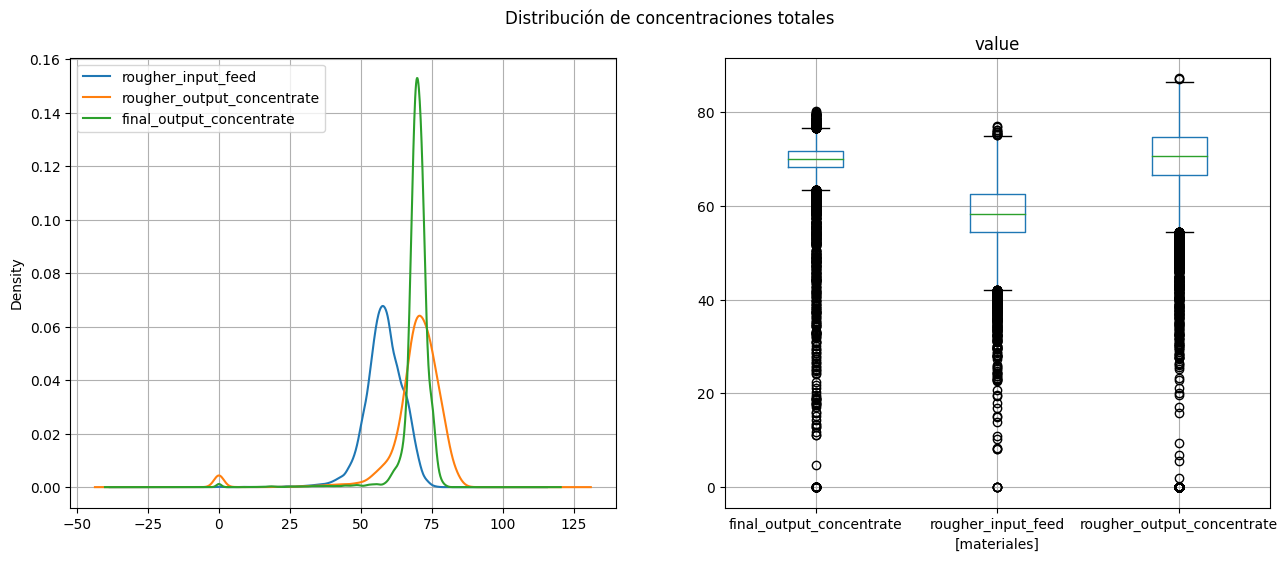

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
for col in conc_totals.columns:
    conc_totals[col].plot.kde(label=col, ax=ax[0])
ax[0].grid()
ax[0].legend()
conc_totals.melt(value_vars=conc_totals.columns).rename(columns={'variable' : 'materiales'})\
        .boxplot(by='materiales', ax=ax[1])
fig.suptitle(f'Distribución de concentraciones totales')
fig.show()

**Observaciones**

Con los gráficos anteriores podemos observar como en las tres etapas si se tienen valores atípicos, observando en el gráfico de la izquierda la distribución que muestra un pequeño pico en los valores cercanos a cero, con el fin de tener la mayor cantidad de valores consistentes, empelaremos una técnica para descartar aquellas observaciones que se encuentren debajo del limite de 10%. Aprovecharemos para incluir en el conjunto de prueba las características y variables objetivo que no tenemos disponibles obteniéndolas del conjunto con los datos completos.

In [23]:
lim = 10 # Limite mínimo
data_train_clean = data_train[
    (data_train[rougher_input_feed].sum(axis=1) > lim) &
    (data_train[rougher_output_concentrate].sum(axis=1) > lim) &
    (data_train[final_output_concentrate].sum(axis=1) > lim)
].copy()

# Para utilizar variables de `full` no disponibles en `test`
data_full_test = data_full[data_full['date'].isin(data_test['date'])].reset_index(drop=True)

# Nos quedamos solo las columnas faltantes en test
data_full_test = data_full_test[['date']+cols_tests_unavailable.to_list()]

# Unimos con `test` utilizando la misma fecha
data_test_clean = data_test.merge(data_full_test, on='date', how='left')

data_test_clean = data_test_clean[
    (data_test_clean[rougher_input_feed].sum(axis=1) > lim) &
    (data_test_clean[rougher_output_concentrate].sum(axis=1) > lim) &
    (data_test_clean[final_output_concentrate].sum(axis=1) > lim)
][data_train_clean.columns.values].copy()

In [ ]:
data_train_clean.shape

In [24]:
data_test_clean.shape

(4969, 87)

**Observaciones**

Considerando el tamaño inicial que tenía nuestro conjunto de entrenamiento que era de `16860`, hemos tenido una reducción considerable, sin embargo los datos descartados nos ayudarán a tener un conjunto consistente que ayudará a un mejor entrenamiento de nuestro modelo.

## <a id='toc1_5_'></a>[Construyendo el modelo](#toc0_)

Nuestra métrica con la que determinaremos la eficiencia de nuestro modelo es *sMAPE*, expresada de la siguiente forma, considerando que tenemos dos variables objetivo que debemos obtener, una vez obtenido el *sMAPE* obtendremos la métrica final, el *sMAPE final*.

Necesitamos predecir dos valores:
1. La recuperación del concentrado rougher `rougher.output.recovery`.
2. La recuperación final del concentrado `final.output.recovery`.

$$
\text{sMAPE} = \frac{1}{N} \sum_{i=1}^{N} \frac{|y_i - \hat{y}_i|}{(|y_i| + |\hat{y}_i|)/2} \times 100\%
$$

$$
\text{sMAPE final} = 25\% \times \text{sMAPE}{\text{(rougher)}} + 75\% \times \text{sMAPE}{\text{(final)}}
$$

In [ ]:
def smape(y_true, y_pred):
    return np.mean( np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true))/2)) * 100

In [ ]:
def final_smape(y_true, y_pred):
    rougher_true = y_true.iloc[::,0].reset_index(drop=True)
    final_true = y_true.iloc[::,1].reset_index(drop=True)
    rougher_pred = pd.DataFrame(y_pred).iloc[::,0]
    final_pred = pd.DataFrame(y_pred).iloc[::,1]
    
    smape_rougher = smape(rougher_true, rougher_pred)
    smape_final = smape(final_true, final_pred)
    return (0.25 * smape_rougher) + (0.75 * smape_final)

In [ ]:
def final_smape_s(y_true, y_pred):
    rougher_true = y_true.iloc[:,0]
    final_true = y_true.iloc[:,1]
    rougher_pred = pd.DataFrame(y_pred).iloc[:,0]
    final_pred = pd.DataFrame(y_pred).iloc[:,1]
    
    smape_rougher = smape(rougher_true, rougher_pred)
    smape_final = smape(final_true, final_pred)
    return (0.25 * smape_rougher) + (0.75 * smape_final)

In [ ]:
# Estableciendo nuestra métrica para la validación cruzada
smape_scorer = make_scorer(final_smape, greater_is_better=False)

In [ ]:
def validate_model(model, X, y):
    return np.abs(np.mean(cross_val_score(model, X, y, scoring=smape_scorer)))

**Entrenando diferentes modelos**

Cada modelo será evaluado aplicando la validación cruzada. Al final determinaremos el más optimo según nuestra métrica.

In [ ]:
# Separamos nuestras características y variables objetivo.
features_train = data_train_clean.drop(columns=['date', 'rougher.output.recovery', 'final.output.recovery'])
target_train = data_train_clean[['rougher.output.recovery', 'final.output.recovery']]

features_test = data_test_clean.drop(columns=['date', 'rougher.output.recovery', 'final.output.recovery'])
target_test = data_test_clean[['rougher.output.recovery', 'final.output.recovery']]

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

In [ ]:
%%time
state = np.random.RandomState(RANDOM_STATE)
for depth in range(5, 11, 1):
    model = DecisionTreeRegressor(max_depth=depth, random_state=state)
    model.fit(features_train, target_train)
    final_smape_score = validate_model(model, features_train, target_train)
    print("max_depth =", depth, ":", final_smape_score)

In [ ]:
%%time
state = np.random.RandomState(RANDOM_STATE)
for estimators in [10, 20]:
    model = RandomForestRegressor(n_estimators=estimators, random_state=state)
    model.fit(features_train, target_train)
    final_smape_score = validate_model(model, features_train, target_train)
    print("n_estimators =", estimators, ":", final_smape_score)

**Conclusiones**

Tras evaluar dos diferentes modelos, ambos basados en árboles, determinamos que el modelo que obtiene un mejor *final sMAPE* es el modelo de `RandomForestRegressor`, con un *n_estimators* de 20.

### <a id='toc1_5_1_'></a>[Evaluando modelo final](#toc0_)

Entrenemos nuestro mejor modelo y probemos con nuestro conjunto de prueba.

In [ ]:
%%time
model = RandomForestRegressor(n_estimators=20, random_state=RANDOM_STATE)
model.fit(features_train, target_train)
preds = model.predict(features_test)

In [ ]:
final_smape(target_test, preds)

**Conclusiones**

Nuestro *sMAPE final* con nuestro modelo más óptimo es de **1.78**. 

**Prueba de cordura**

Por último visualicemos si nuestro modelo tendría una puntuación mejor que un modelo que simplemente obtenga la media para cada observación.

In [ ]:
random_predicts = [[target_test.mean()[0], target_test.mean()[1]]]*len(target_test)

In [ ]:
final_smape(target_test, random_predicts)

El *sMAPE final* de un modelo cuyas predicciones sea siempre la media, obtiene una puntuación de **6.42**, por lo que podemos determinarque neustro modelo es mejor que simplemente completar con la media.

## <a id='toc1_6_'></a>[Conclusiones finales](#toc0_)

**Exploración de datos**

Explorando nuestros conjuntos de datos determinamos el tipo de dato, cantidad de columnas y la existencia de valores ausentes en cada uno. Debido a la cantidad de valores totales y el porcentaje que representaban los valores ausentes se optó por simplemente descartar los valores para mantener solo valores consistentes. Se hizo una comprobación del *cálculo de recuperación*.

**Análisis de datos**

En la exploración de nuestros datos observamos como en nuestro conjunto de prueba faltaban algunas columnas, esto lo consideramos para poder incluir las características faltantes además de las variables objetivo. Observamos la concentración de metales en cada etapa, pudiendo observar como era el oro el único metal cuya concentración crecía con cada etapa. También validamos las distribuciones del tamaño de las partículas de la alimentación, tanto para el conjunto de pruebas como entrenamiento, para poder determinar si estos valores eran confiables, ya que de ser diferente la distribución tendríamos problemas con nuestro modelo. Por último visualizamos las concentraciones totales de todas las sustancias en las diferentes etapas, para poder encontrar alguna anomalía.

**Procesamiento de datos**

Además de la eliminación de valores ausentes, eliminamos aquellas observaciones cuya sumatoria total de los metales estuviera por debajo de *10*, esto derivado de observar las concentraciones totales de todas las sustancias y observar este umbral. Por último añadimos las columnas faltantes en nuestro modelo de prueba, columnas obtenidas del conjunto con los valores totales.

**Entrenamiento de modelo**

Entrenamos dos modelos diferentes, el primero siendo `DecisionTreeRegressor` obteniendo un *sMAPE final* promedio de 3.8, y un segundo modelo de `RandomForestRegressor` con un *sMAPE final* promedio de 2.3, la puntuación en estas pruebas fue el promedio de la validación cruzada con el que se evaluó cada modelo. Por último simulamos un modelo que en cada predicción devolviera el valor medio, obteniendo un *sMAPE final* de 6.42. Con esto construimos nuestro mejor modelo con `RandomForestRegressor` obteniendo un *sMAPE final* de 1.78, concluyendo que nuestro modelo es mejor que solo regresar la media.